In [1]:
"""
Two examples before are classification problems. Their objectives are to predicting a label for given input data point. Another type of
machine learning problem is regression, which predicts continuous values instead of individual labels. For example, it can be used to
predict tomorrow's temperature given climate data, or predict time to finish the software process given software specification.
(Regression and logistic regression are different. Logistic regression is NOT a regression problem, but rather classification problem)

We will try to predict medium of housing price given crime rate, local tax rate, etc in Boston suburban area in 1970. The data set we
will use here is different from that of two examples before. There are 506 data points in total, which is pretty small, where 404 of
them are training samples and 102 of them are test samples. Each features in the input data has different scales. For example, some have
value between 0 and 1, some have value between 1 and 12, some have value between 1 and 100, etc.
"""

from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print(train_data.shape)
print(test_data.shape)

"""
As we can see here, there are 404 training samples and 102 test samples, and they all have 13 features. These features are crime rate,
average room number, and accessibility to highway, etc. Target is medium price of housing in thousand dollars.
"""

print(train_targets)

"""
These prices are normally in between $10000 and $50000.

It becomes a problem when we try to input values with different scales in neural network. Network can try to adjust with these data,
but it surely makes the learning harder. If the scale of the features differ, path of gradient descent, which finds the absolute
minimum, is more affected by features with bigger scales. Typical way to handle this data is to standardize the data by features.
To do this, we need to do (x - mean)/(standard deviation) for each feature. Mean of the feature becomes 0 and standard deviation becomes
1. We can use numpy to simply do this.
"""

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

"""
Notice that the values used to standardize test data are values that we have calculated in training data. We should not use any values
that we have calculated from test data in the process of machine learning.

Since there are small number of samples, we will use a small network with 2 hidden layers with 64 hidden units. Since overfitting often
happens when there are small number of training data, we need to use small model to prevent it.
"""

from keras import models
from keras import layers

#Since we will generate same model some times, we will create a function
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mean_absolute_error'])
    return model
    
"""
The last layer of this network has one output unit and does not have activation function (this is called linear layer). This is a 
typical configuration for scalar regression (regression that predicts one continuous value). If we apply activation function it will
limit the range of the output. For example, if we use sigmoid as activation function for last layer, network will output values ranged
only from 0 to 1. In here, since last layer is purely linear, network will be able to output any real number. This model uses mse, or
mean squared error, as loss function. It is square of difference between prediction and target. We will measure mean absolute error 
(mae) to monitor the process of training. It is an absolute value of difference between prediction and target.

We divide data into training set and validation set to evaluate the model by adjusting variables like number of epochs. Since there are
small number of data points, there will be small number of validation sets (approximately 100 samples). Therefore, validation score
will greatly differ depending on what data point was selected as training set or validation set. In other words, variance of validation
score for selection of validation set is high. We cannot do trustworthy validation like this. The best way to solve this situation is 
K-fold cross-validation. We divide the data to K folds (usually K = 4 or 5) and create K models and train with K - 1 folds and validate
with the other fold. The model's validation score becomes the mean of K validation scores from each model.
"""

import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    #A particular fold becomes validation fold
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    #Fold other than our validation fold becomes training fold
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    #verbose=0 means that there will be no output of training process
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

print(all_scores)
print(np.mean(all_scores))

(404, 13)
(102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


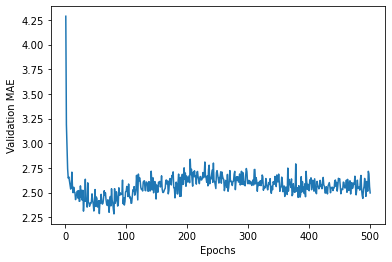

In [2]:
"""
We can see that validation set varies a lot from 2.4 to 2.8. Their mean value (2.56) is more trustworthy than each of the scores. This
is the main point of K-fold cross-validation. In this example, mean absolute error is approximately 2560 dollars. This is pretty high
considering that the housing price ranges from 10000 dollars to 50000 dollars.

We will try to train neural network longer, for 500 epochs. We will save each epoch's validation score so that we can know how model 
improves for each epoch.
"""

num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, 
                        validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

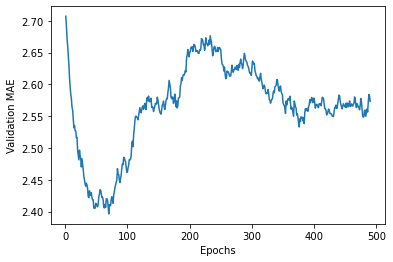

In [3]:
"""
Since this graph has high range and fluctuations, it is hard to interpret by eyes. Let's:
1. Remove first 10 data points that differs a lot from other data points
2. Substitute each point with exponential moving average of previous point to get smoother curve
"""

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [4]:
"""
If we look at this graph, we can see that validation MAE stopped decreasing after 80th epoch. Overfitting starts after this point.
After tuning various variables of model (such as number of epochs, size of hidden layers, etc), we use all training data and train model
to be used in practice with best variables. Then, we check the performance with the test data.
"""

model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print(test_mae_score)

4/4 [==============================] - 0s 750us/step - loss: 19.1272 - mean_absolute_error: 2.8144
2.814420223236084
